# 03_visualizations.ipynb — Visual analytics

本 Notebook 聚焦於 **視覺化分析**：
- 感測器分布與群組箱型圖（`Pass/Fail`）
- PCA（降維）與解釋變異、2D/3D 視覺化
- 相關係數熱圖（Top 變異感測器）
- 小型多圖（小倍圖）對比 PASS vs FAIL 的感測器分佈

> 作圖僅使用 `matplotlib`（不使用 seaborn）。


它包含：

- Top 變異感測器的直方圖與按 Pass/Fail 分組的箱型圖
- 相關係數熱圖（取 Top 變異感測器，缺失以中位數暫填供作圖）
- PCA（含解釋變異比例、PC1–PC2 散佈圖、3D 散佈圖；若環境無 sklearn 會自動略過）
- 小倍圖：按群組疊圖比較感測器分佈
- 所有圖會輸出到 plots/ 方便你在 README 或報告中引用

In [1]:
# === Imports & Settings ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 180)

%matplotlib inline

# Sklearn for PCA (optional)
try:
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    SKLEARN_AVAILABLE = True
except Exception as e:
    SKLEARN_AVAILABLE = False


In [2]:
# === Load Data ===
candidate_paths = [
    os.path.join('data', 'uci-secom.csv'),
    '../data/uci-secom.csv'
]

csv_path = None
for p in candidate_paths:
    if os.path.exists(p):
        csv_path = p
        break

if csv_path is None:
    raise FileNotFoundError("找不到 uci-secom.csv，請放到 ./data 或使用上傳路徑。")

df = pd.read_csv(csv_path)
print('Loaded:', csv_path, ' shape=', df.shape)

# 目標欄位
target_candidates = [c for c in df.columns if str(c).lower() in ['pass/fail', 'y', 'target', 'label']]
target_col = target_candidates[0] if len(target_candidates) > 0 else None
print('Target column:', target_col)

# 轉換 PASS/FAIL
if target_col is not None:
    mapping = {1: 'PASS', -1: 'FAIL', 0: 'FAIL'}
    df['_y_group_'] = df[target_col].map(lambda v: mapping.get(v, v))
else:
    df['_y_group_'] = np.nan

# 數值感測器欄位
sensor_cols = []
for c in df.columns:
    if c == target_col or str(c).lower() == 'time':
        continue
    if pd.api.types.is_numeric_dtype(df[c]):
        sensor_cols.append(c)

print('Numeric sensor columns:', len(sensor_cols))

# 圖檔輸出資料夾
plot_dir = 'plots-pca'
os.makedirs(plot_dir, exist_ok=True)


Loaded: ../data/uci-secom.csv  shape= (1567, 592)
Target column: Pass/Fail
Numeric sensor columns: 590


Top-variance sensors: ['162', '161', '297', '24', '296', '23']


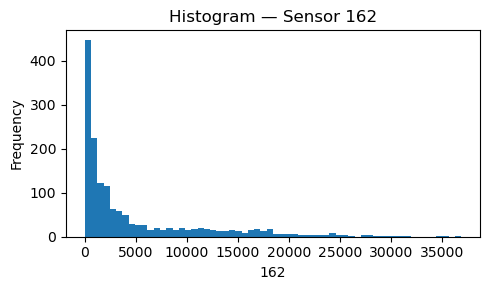

C:\Users\jackl\AppData\Local\Temp\ipykernel_8164\424963222.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(group_vals, labels=labels, showfliers=False)


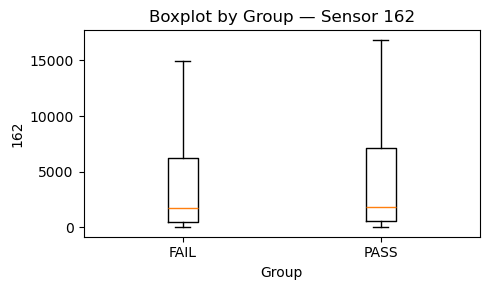

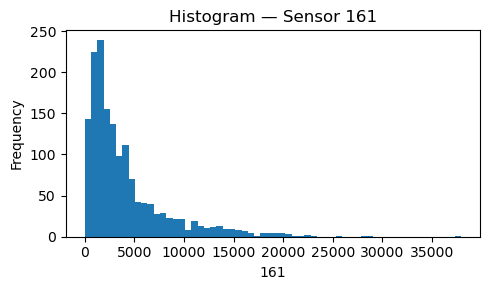

C:\Users\jackl\AppData\Local\Temp\ipykernel_8164\424963222.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(group_vals, labels=labels, showfliers=False)


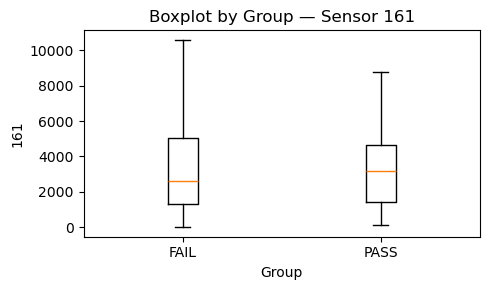

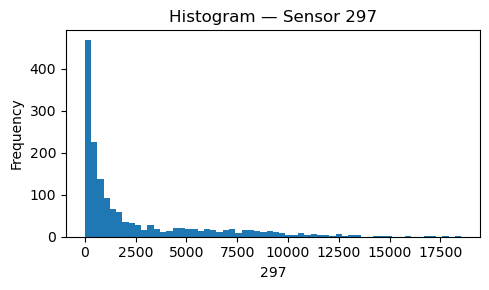

C:\Users\jackl\AppData\Local\Temp\ipykernel_8164\424963222.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(group_vals, labels=labels, showfliers=False)


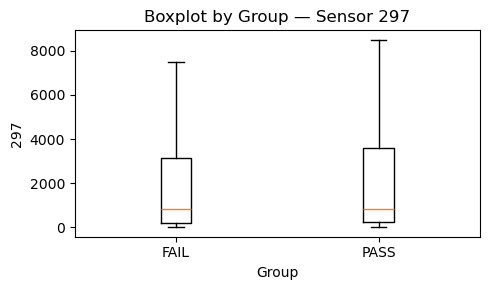

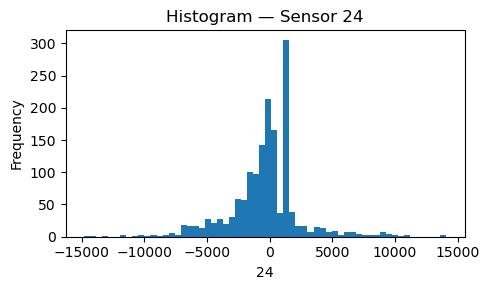

C:\Users\jackl\AppData\Local\Temp\ipykernel_8164\424963222.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(group_vals, labels=labels, showfliers=False)


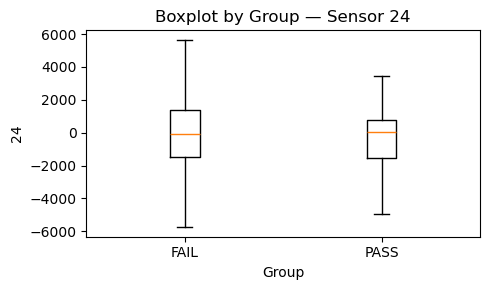

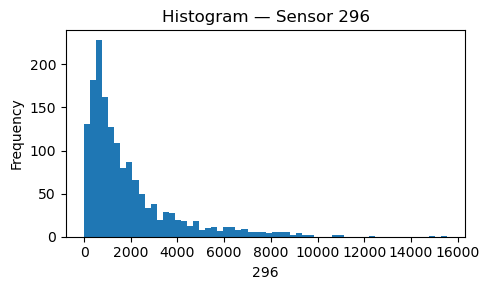

C:\Users\jackl\AppData\Local\Temp\ipykernel_8164\424963222.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(group_vals, labels=labels, showfliers=False)


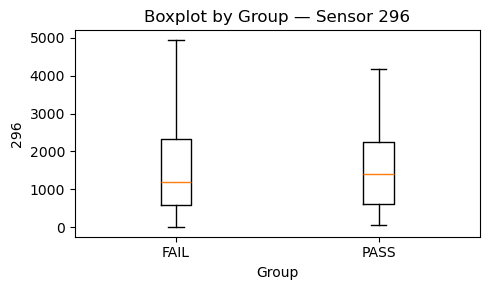

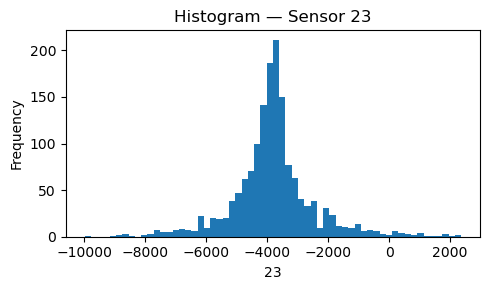

C:\Users\jackl\AppData\Local\Temp\ipykernel_8164\424963222.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(group_vals, labels=labels, showfliers=False)


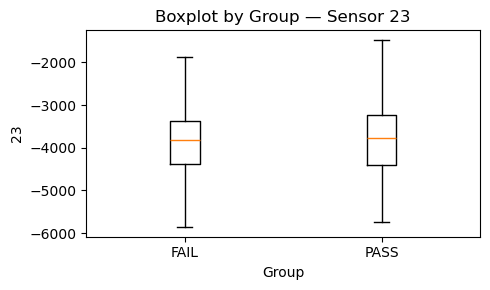

In [3]:
# === Single-sensor Distributions & Boxplots by Group ===
# 依據變異度選出 Top-K 感測器，進行分布直方圖與分組箱型圖
K = 6
var_series = df[sensor_cols].var(numeric_only=True).sort_values(ascending=False)
top_sensors = var_series.head(K).index.tolist()
print('Top-variance sensors:', top_sensors)

for c in top_sensors:
    s = df[c].dropna()
    if len(s) == 0:
        continue
    
    # Histogram
    plt.figure(figsize=(5,3))
    plt.hist(s, bins=60)
    plt.xlabel(str(c))
    plt.ylabel('Frequency')
    plt.title(f'Histogram — Sensor {c}')
    plt.tight_layout()
    out = os.path.join(plot_dir, f'hist_{c}.png')
    plt.savefig(out, dpi=140)
    plt.show()
    
    # Boxplot by group
    if '_y_group_' in df.columns and df['_y_group_'].notna().any():
        group_vals = []
        labels = []
        for g, gdf in df.groupby('_y_group_'):
            vals = gdf[c].dropna().values
            if len(vals) > 0:
                group_vals.append(vals)
                labels.append(str(g))
        if len(group_vals) >= 2:
            plt.figure(figsize=(5,3))
            plt.boxplot(group_vals, labels=labels, showfliers=False)
            plt.xlabel('Group')
            plt.ylabel(str(c))
            plt.title(f'Boxplot by Group — Sensor {c}')
            plt.tight_layout()
            out = os.path.join(plot_dir, f'box_{c}.png')
            plt.savefig(out, dpi=140)
            plt.show()


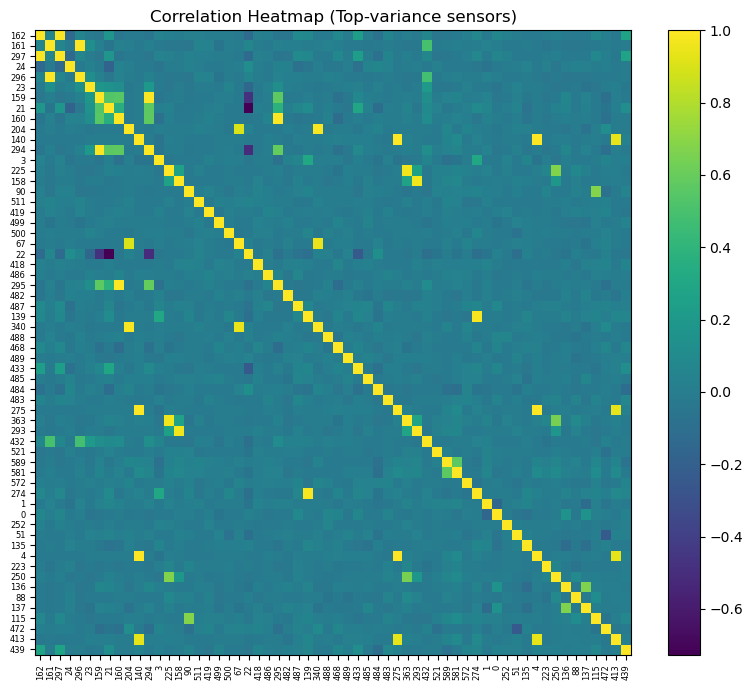

In [4]:
# === Correlation Heatmap (Top-variance sensors) ===
# 相關性在大量缺失下會受影響，先對各欄位做簡單中位數填補（僅為了視覺化；建模前應更審慎處理）
top_for_corr = 60  # 取前 60 個變異最大的感測器
sel_cols = var_series.head(top_for_corr).index.tolist()

X_sel = df[sel_cols].copy()
for c in sel_cols:
    med = X_sel[c].median(skipna=True)
    X_sel[c] = X_sel[c].fillna(med)

corr = X_sel.corr().values

plt.figure(figsize=(8,7))
plt.imshow(corr, aspect='auto', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Heatmap (Top-variance sensors)')
plt.xticks(range(len(sel_cols)), [str(c) for c in sel_cols], rotation=90, fontsize=6)
plt.yticks(range(len(sel_cols)), [str(c) for c in sel_cols], fontsize=6)
plt.tight_layout()
out = os.path.join(plot_dir, 'corr_heatmap_topvar.png')
plt.savefig(out, dpi=150)
plt.show()


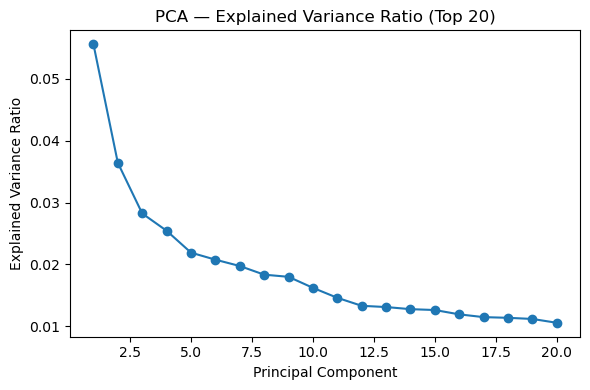

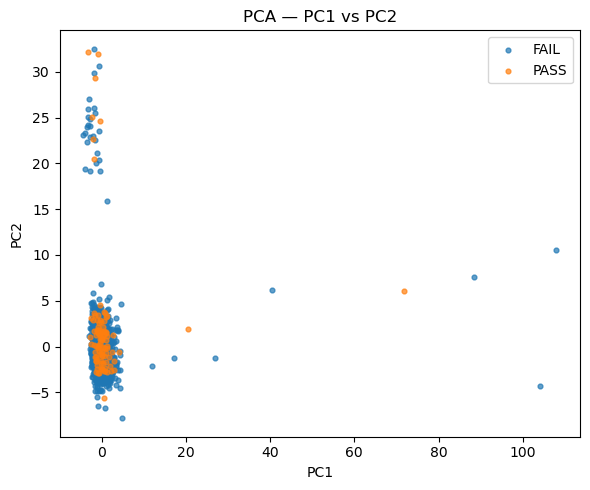

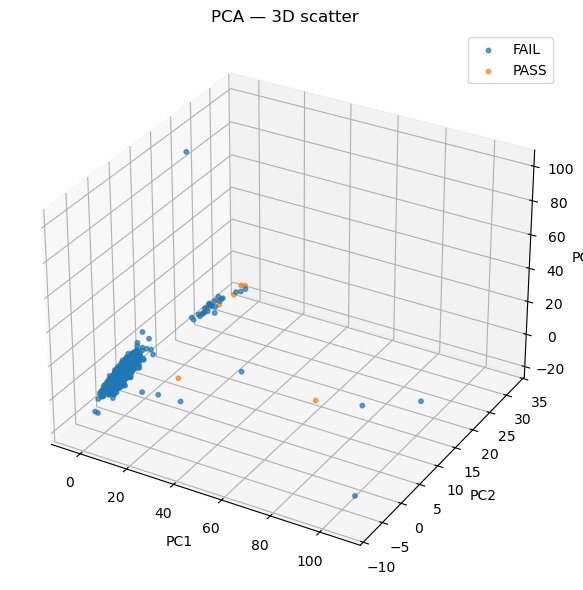

In [5]:
# === PCA Visualization ===
if SKLEARN_AVAILABLE and len(sensor_cols) > 0:
    # 簡單中位數填補 + 標準化
    X = df[sensor_cols].copy()
    for c in sensor_cols:
        med = X[c].median(skipna=True)
        X[c] = X[c].fillna(med)
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X.values)
    
    # 解釋變異比例（前 20 主成分）
    pca = PCA(n_components=min(20, X_std.shape[1]))
    X_pca = pca.fit_transform(X_std)
    evr = pca.explained_variance_ratio_
    
    plt.figure(figsize=(6,4))
    plt.plot(np.arange(1, len(evr)+1), evr, marker='o')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA — Explained Variance Ratio (Top 20)')
    plt.tight_layout()
    out = os.path.join(plot_dir, 'pca_explained_variance.png')
    plt.savefig(out, dpi=140)
    plt.show()
    
    # 2D Scatter: PC1 vs PC2
    if '_y_group_' in df.columns and df['_y_group_'].notna().any():
        groups = df['_y_group_'].astype(str).fillna('UNK').values
    else:
        groups = np.array(['ALL'] * len(df))
    
    plt.figure(figsize=(6,5))
    # 用不同群組分層作圖（顏色由 matplotlib 自動指派）
    uniq = pd.unique(groups)
    for g in uniq:
        idx = (groups == g)
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1], s=12, label=g, alpha=0.7)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA — PC1 vs PC2')
    plt.legend()
    plt.tight_layout()
    out = os.path.join(plot_dir, 'pca_scatter_pc1_pc2.png')
    plt.savefig(out, dpi=140)
    plt.show()
    
    # 3D Scatter（若維度允許）
    if X_pca.shape[1] >= 3:
        from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
        fig = plt.figure(figsize=(7,6))
        ax = fig.add_subplot(111, projection='3d')
        for g in uniq:
            idx = (groups == g)
            ax.scatter(X_pca[idx, 0], X_pca[idx, 1], X_pca[idx, 2], s=10, label=g, alpha=0.7)
        ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
        ax.set_title('PCA — 3D scatter')
        ax.legend()
        plt.tight_layout()
        out = os.path.join(plot_dir, 'pca_scatter_3d.png')
        plt.savefig(out, dpi=160)
        plt.show()
else:
    print("sklearn 不可用或無有效感測器欄位，略過 PCA。")


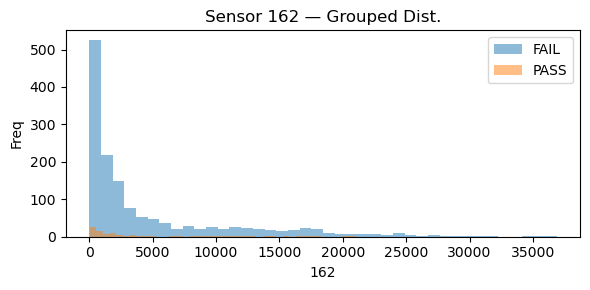

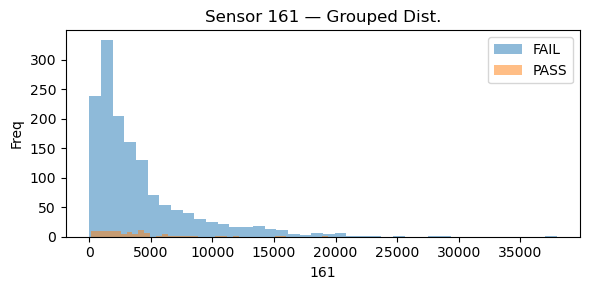

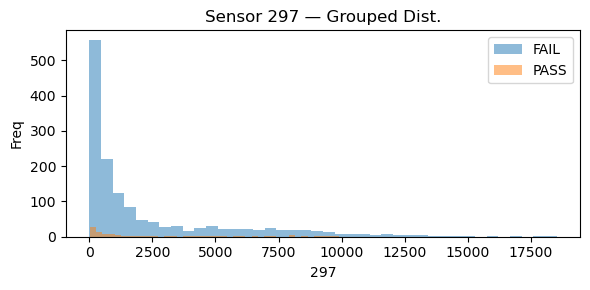

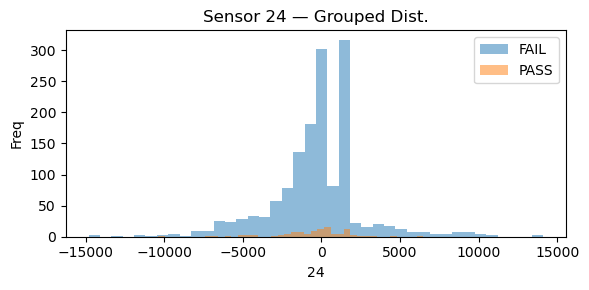

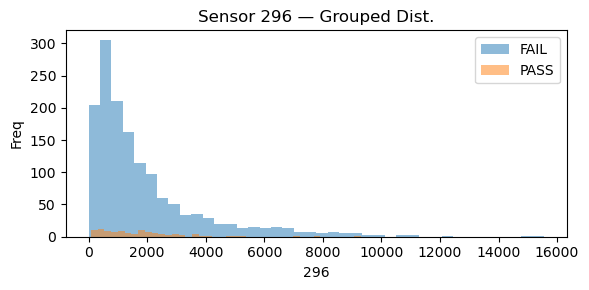

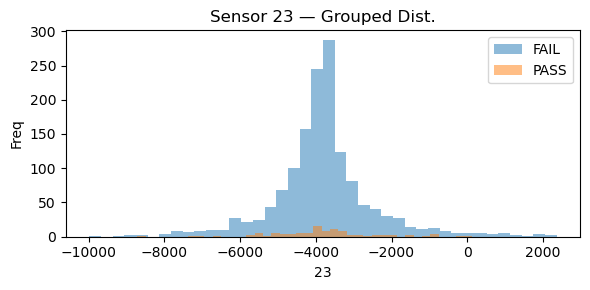

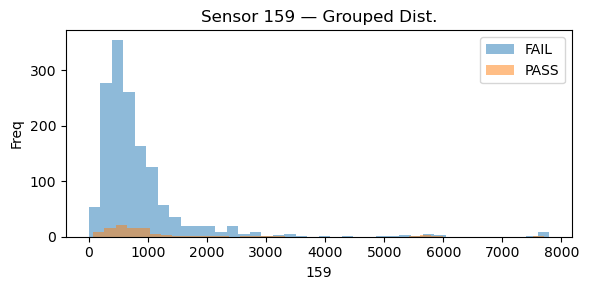

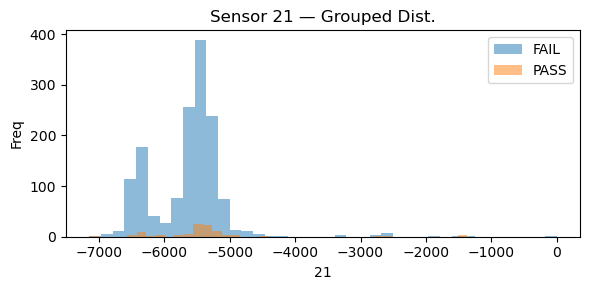

In [6]:
# === Small Multiples: Selected Sensors by Group ===
# 取 Top-variance 的前 8 個感測器，分組畫小倍圖直方圖（PASS vs FAIL）
M = 8
sel = var_series.head(M).index.tolist()
rows = 4
cols = 2
fig_idx = 1

for i, c in enumerate(sel):
    gdf = df[['_y_group_', c]].dropna()
    if gdf.empty:
        continue
    
    # 建立子圖
    plt.figure(figsize=(6,3))
    if '_y_group_' in gdf.columns:
        uniq = gdf['_y_group_'].dropna().unique().tolist()
        for g in uniq:
            vals = gdf[gdf['_y_group_'] == g][c].values
            plt.hist(vals, bins=40, alpha=0.5, label=str(g))
        plt.legend()
    else:
        plt.hist(gdf[c].values, bins=40)
    plt.xlabel(str(c))
    plt.ylabel('Freq')
    plt.title(f'Sensor {c} — Grouped Dist.')
    plt.tight_layout()
    out = os.path.join(plot_dir, f'small_multi_{c}.png')
    plt.savefig(out, dpi=140)
    plt.show()


In [7]:
# === Notes ===
print("""說明：
1) 視覺化前採用簡單中位數填補是為了避免因缺失而無法作圖；建模前請改用更嚴謹的方法（例如 KNNImputer 或依製程階段分組填補）。
2) PCA 圖可用於快速觀察 Pass/Fail 在低維空間的可分性；若重疊嚴重，建議考慮非線性方法（如 t-SNE/UMAP）。
3) 相關熱圖僅對 Top 變異感測器繪製，以降低 O(n^2) 計算成本與視覺雜訊。
4) 若類別極度不平衡，圖形中的 FAIL 分布可能不足以代表全體，建議在抽樣或權重上做調整以輔助觀察。
""")

說明：
1) 視覺化前採用簡單中位數填補是為了避免因缺失而無法作圖；建模前請改用更嚴謹的方法（例如 KNNImputer 或依製程階段分組填補）。
2) PCA 圖可用於快速觀察 Pass/Fail 在低維空間的可分性；若重疊嚴重，建議考慮非線性方法（如 t-SNE/UMAP）。
3) 相關熱圖僅對 Top 變異感測器繪製，以降低 O(n^2) 計算成本與視覺雜訊。
4) 若類別極度不平衡，圖形中的 FAIL 分布可能不足以代表全體，建議在抽樣或權重上做調整以輔助觀察。

